In [ ]:
import os
import sys
import time
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import h5py
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as krad
from scipy.optimize import curve_fit, leastsq
from IPython.display import Image, display
from tqdm import tqdm
from scipy.stats import gaussian_kde

import seaborn as sns

sns.set_theme('talk')
sns.set_style('whitegrid', {'xtick.bottom':True, 'ytick.left':True})
sns.plotting_context('talk')

H0 = 100
Om0=0.3065
Ode0 = 1-Om0
light_c = 2.99792458e5
ulim=0.5

### Funcs

In [3]:
def lumdist(z):
    '''
    Calculates the luminosity distance based on given redshift. Uses cubic spline to approximate the result.

    Arguments:
        z: The redshift should be input as a Numpy array

    '''
    z = np.array(z)
    z_max = z.max()

    reds = np.linspace(0,z_max,1000)
    zez = []
    for i in reds:
        zaz = sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return (1+z) * 2.99792458*10**5/H0 * sp.interpolate.interp1d(reds, zez)(z)

def lumdist_err(z,z_err):
    '''
    Calculates the associated upper and lower luminosity distance error based on the given redshift and associated error. 
    The reason for separate errors is that since redshift isn't linearly related to luminosity distance, the transformation doesn't result in the same amount of error.

    Arguments:
        Input: Should be given as a Numpy array
        Output: Numpy array in the form [lower error, upper error]
    
    '''
    z = np.array(z)
    z_err = np.array(z_err)
    
    lowerr = lumdist(z) - lumdist(z-z_err)
    uperr = lumdist(z+z_err) - lumdist(z)

    return np.array([lowerr,uperr])

def z_from_dl(dl):
    '''
    Returns the redshift based on the given luminosity distance in units of Mpc.

    Arguments:
        dl: The luminosity distance should be input as a Numpy array
    
    '''
    dl = np.array(dl)
    reds = np.linspace(0,10,1000)
    zez = []
    for i in reds:
        zaz = (1+i) * 2.99792458*10**5/H0 * sp.integrate.quad(lambda x:(1/np.sqrt(Om0*(1+x)**3 + Ode0)), 0, i)[0]
        zez.append(zaz)

    return sp.interpolate.CubicSpline(zez,reds)(dl)

def E(x):
    return 1/(np.sqrt(Ode0 + Om0 * (1+x)**3))

#single schechter
def func(x, M_star, alpha, phi):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

#double schechter
def doubfunc(x, M_star, alpha1, phi1, alpha2, phi2):
    return 0.4*np.log(10)*(phi1*10**(-0.4*(1+alpha1)*(x-M_star))+phi2*10**(-0.4*(1+alpha2)*(x-M_star)))*np.exp(-1*(10)**(-0.4*(x-M_star)))

def colorcorr(bandname, redshift, colv, colv1, colm, colm1):
    """
    Calculates k-corrections based on Beare-Brown (2014) paper. Is used for g, r, i, z bands.

    Arguments:
        Input: Should be Numpy arrays or float values!
        bandname: Should be a String, in the form 'x'.
    """
    from scipy.interpolate import CubicSpline
    import numpy as np
    
    bandname=str(bandname)

    z_array = np.array(np.linspace(0,0.5,51))

    coeff_dict = {      'g':np.array((np.array([0.0000,-0.0161,-0.0334,-0.0505,-0.0642,-0.0930,-0.1483,-0.2178,-0.2863,-0.2469,-0.2673, -0.2686,-0.2478,
                                               -0.2101,-0.1466,-0.0999,-0.0810,-0.0662,-0.0553,-0.0450,-0.0346,-0.0253,-0.0165,-0.0073,0.0008,0.0103,
                                                0.0195,0.0272,0.0352,0.0433,0.0498,0.0544,0.0576,0.0530,0.0336, -0.1596,-0.3490,-0.3862,-0.4522,-0.4112,
                                               -0.2755,-0.2729,-0.4159,-0.2909,-0.2102,-0.1557,-0.1158,-0.0963,-0.0869,-0.0689,-0.0515]),
                                     np.array([1.0000,0.9609,0.9318,0.9121,0.8932,0.8968,0.9413,1.0152,1.0950,1.0078,1.0099,0.9839,0.9220,0.8327,0.7121,
                                               0.6052,0.5368,0.4767,0.4237,0.3743,0.3263,0.2819,0.2402,0.1981,0.1578,0.1139,0.0695,0.0270,-0.0163,-0.0588,
                                               -0.0972,-0.1296,-0.1585,-0.1635,-0.1229,1.0195,1.1784,1.1818,1.2146,1.1259,0.9552,0.8673,0.9411,0.7830,0.6659,
                                               0.5740,0.4960,0.4440,0.4000,0.3441,0.2927]),
                                     np.array([0.0000,0.0146,0.0243,0.0279,0.0292,0.0227,0.0009,-0.0347,-0.0753,-0.0544,-0.0641,-0.0638,-0.0493,-0.0229,
                                               0.0087,0.0436,0.0697,0.0928,0.1142,0.1345,0.1551,0.1749,0.1936,0.2134,0.2334,0.2559,0.2795,0.3032,0.3283,
                                               0.3538,0.3784,0.3999,0.4195,0.4210,0.3873,0.2986,0.2528,0.2437,0.2282,0.2466,0.2786,0.3045,0.2938,0.3268,
                                               0.3523,0.3734,0.3927,0.4057,0.4169,0.4330,0.4475]))),

                        'r':np.array((np.array([-0.0910, -0.0938, -0.0946, -0.0911, -0.0826, -0.0609, -0.0361, -0.0090, -0.0103,-0.0112, -0.0148, -0.0141,
                                                -0.0156, -0.0193, -0.0170, -0.0236, -0.0558, -0.0356,-0.0162, -0.0146, -0.0115, -0.0093, -0.0074, -0.0078,
                                                -0.0148, -0.0360, 0.0184,0.0653, 0.0985, 0.1173, 0.1263, 0.1274, 0.1221, 0.1106, 0.0937, 0.0690, 0.0291,
                                                -0.0337, -0.0442, -0.0621, -0.0626, -0.0637, -0.1234, -0.1298, -0.1229, -0.1148,-0.1050, -0.0889, -0.0796,
                                                -0.0852, -0.0819]),
                                     np.array([0.5390, 0.5250, 0.5045, 0.4742, 0.4325, 0.3587, 0.2782, 0.1915, 0.1717, 0.1553,0.1479,0.1297,0.1183,0.1174,
                                                0.1024, 0.1181, 0.2072, 0.1366, 0.0696, 0.0593,0.0465, 0.0369, 0.0282, 0.0277, 0.0515, 0.1261, 0.2922, 0.1758,
                                                0.0850, 0.0219,-0.0214, -0.0476, -0.0599, -0.0574, -0.0431, -0.0151, 0.0483, 0.1584, 0.1685, 0.1963, 0.1862,
                                                0.1849, 0.3061, 0.3129, 0.2957, 0.2770, 0.2525, 0.2133, 0.1930, 0.2053, 0.1973]),
                                     np.array([-0.1256, -0.1223, -0.1114, -0.0927, -0.0652, -0.0155, 0.0381, 0.0949, 0.1103, 0.1200, 0.1225, 0.1324, 0.1383,
                                                0.1363, 0.1448, 0.1279, 0.0577, 0.1118, 0.1616, 0.1663, 0.1724, 0.1763, 0.1794, 0.1736, 0.1437, 0.0672, 0.2477,
                                                0.3068, 0.3544,0.3891, 0.4145, 0.4303, 0.4376, 0.4358, 0.4273, 0.4136, 0.3800, 0.3236, 0.3161, 0.2983, 0.3020,
                                                0.2960, 0.2260, 0.2200, 0.2245, 0.2294, 0.2388, 0.2569, 0.2615, 0.2486, 0.2473]))),

                        'i':np.array((np.array([0.0584,0.0531,0.0483,0.0280,-0.0154,-0.0483,-0.0520,-0.0532,-0.0518,-0.0394,-0.0177,0.0045,0.0193,0.0237,
                                               0.0222,0.0183,0.0136,0.0089,0.0044,0.0007,-0.0027,-0.0049,-0.0037,0.0070,0.0325,0.0780,0.1457,0.1765,0.2327,
                                               0.2633,0.2812,0.2876,0.3302,0.3467,0.4001,0.4973,0.5611,0.4876,0.4757,0.4459,0.4466,0.4382,0.3434,0.3134,0.3047,
                                               0.2978,0.2941,0.3018,0.2944,0.2588,0.2414]),
                                     np.array([0.2701,0.2604,0.2614,0.2841,0.3320,0.3548,0.3359,0.3140,0.2890,0.2501,0.1989,0.1474,0.1070,0.0809,0.0634,0.0497,
                                               0.0376,0.0264,0.0154,0.0036,-0.0088,-0.0243,-0.0472,-0.0886,-0.1582,-0.2640,-0.4124,-0.5175,-0.6439,-0.7231,-0.7765,
                                               -0.8052,-0.8873,-0.9233,-1.0185,-1.1916,-1.3055,-1.1735,-1.1600,-1.1105,-1.1270,-1.1115,-0.9172,-0.8648,-0.8536,-0.8452,
                                               -0.8466,-0.8742,-0.8621,-0.7868,-0.7528]),
                                     np.array([0.0916,0.0941,0.0885,0.0748,0.0549,0.0477,0.0555,0.0646,0.0753,0.0916,0.1124,0.1330,0.1495,0.1609,0.1688,0.1744,0.1789,
                                               0.1831,0.1867,0.1906,0.1954,0.2021,0.2134,0.2345,0.2703,0.3249,0.4014,0.4707,0.5386,0.5844,0.6167,0.6346,0.6683,0.6807,
                                               0.7154,0.7848,0.8272,0.7628,0.7577,0.7342,0.7478,0.7369,0.6328,0.6104,0.6078,0.6060,0.6116,0.6322,0.6258,0.5852,0.5675]))),

                        'z':np.array((np.array([0.0000,-0.0022,-0.0037,-0.0031,0.0045,0.0158,0.0230,0.0299,0.0373,0.0396,0.0322,0.0151,-0.0043,-0.0178,-0.0256,
                                               -0.0294,-0.0318,-0.0324,-0.0318,-0.0310,-0.0304,-0.0281,-0.0223,-0.0067,0.0254,0.0142,0.0793,0.1746,0.2307,0.3376,
                                               0.3667,0.4445,0.3563,0.3882,0.4764,0.6360,0.7203,0.6956,0.7300,0.7033,0.7120,0.7995,0.7383,0.6581,0.6363,0.6142,
                                               0.5944,0.5962,0.5671,0.4863,0.4051]),
                                     np.array([0.0000,-0.0134,-0.0282,-0.0487,-0.0795,-0.1135,-0.1408,-0.1673,-0.1930,-0.2078,-0.2064,-0.1914,-0.1731,-0.1634,-0.1620,
                                               -0.1660,-0.1727,-0.1811,-0.1906,-0.2015,-0.2130,-0.2290,-0.2538,-0.2998,-0.3781,-0.4159,-0.5587,-0.7536,-0.8915,-1.0772,
                                               -1.1461,-1.2830,-1.1652,-1.2202,-1.3660,-1.6372,-1.7760,-1.7140,-1.7856,-1.7380,-1.7696,-1.8883,-1.7210,-1.5900,-1.5690,
                                               -1.5461,-1.5253,-1.5502,-1.5021,-1.3411,-1.1830]),
                                     np.array([0.0000,0.0057,0.0124,0.0221,0.0362,0.0501,0.0608,0.0718,0.0828,0.0904,0.0923,0.0891,0.0846,0.0821,0.0816,0.0819,0.0826,
                                               0.0841,0.0853,0.0873,0.0905,0.0963,0.1077,0.1310,0.1716,0.2116,0.2891,0.3912,0.4724,0.5552,0.5947,0.6529,0.6160,0.6344,
                                               0.6875,0.7952,0.8446,0.8033,0.8382,0.8153,0.8378,0.8695,0.7570,0.7078,0.7095,0.7099,0.7109,0.7354,0.7167,0.6413,0.5701]))) }
    
    if bandname in coeff_dict.keys():
        a1 = CubicSpline(z_array, coeff_dict[bandname][0])
        a = a1(redshift)
        
        b1 = CubicSpline(z_array, coeff_dict[bandname][1])
        b = b1(redshift)
        
        c1 = CubicSpline(z_array, coeff_dict[bandname][2])
        c = c1(redshift)
    else:
        print(f'{bandname} not recognised')
    
    if type(redshift)==np.ndarray:
        kc = np.zeros(len(redshift))
        
        if bandname == 'g':
            
            selection_low = (redshift <= 0.34)
            
            if type(colv)==np.ndarray:
                kc[selection_low] = a[selection_low]*(colv[selection_low])**2 + b[selection_low]*colv[selection_low] + c[selection_low] - colm[selection_low]
                kc[~selection_low] = a[~selection_low]*(colv1[~selection_low])**2 + b[~selection_low]*colv1[~selection_low] + c[~selection_low] - colm1[~selection_low]
            
            elif (type(colv)==np.float64) or (type(redshift)==np.float32):
                    kc[selection_low] = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
                    kc[~selection_low] = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
            
            else:
                raise Exception('No valid color values entered')
    
        elif bandname =='r':
            
            selection_low = (redshift <= 0.25)
            
            if type(colv)==np.ndarray:
                kc[selection_low] = a[selection_low]*(colv[selection_low])**2 + b[selection_low]*colv[selection_low] + c[selection_low] - colm[selection_low]
                kc[~selection_low] = a[~selection_low]*(colv1[~selection_low])**2 + b[~selection_low]*colv1[~selection_low] + c[~selection_low] - colm1[~selection_low]
                
            elif (type(colv)==np.float64) or (type(redshift)==np.float32):
                    kc[selection_low] = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
                    kc[~selection_low] = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1

            else:
                raise Exception('No valid color values entered')
    
        elif bandname=='i':
            kc = a*(colv)**2 + b*(colv) + c - colm
        
        elif bandname=='z':
            kc = a*(colv)**2 + b*(colv) + c
    
        else:
            raise Exception(f'{bandname} not recognised')
            
    elif (type(redshift)==np.float64) or (type(redshift)==np.float32):
        if bandname == 'g':
        
            selection_low = (redshift <= 0.34)
            
            if redshift <= 0.34:
                kc = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
            else:
                kc = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
    
        elif bandname =='r':
            
            selection_low = (redshift <= 0.25)
            
            if redshift <= 0.25:
                kc = a[selection_low]*(colv)**2 + b[selection_low]*colv + c[selection_low] - colm
            else:
                kc = a[~selection_low]*(colv1)**2 + b[~selection_low]*colv1 + c[~selection_low] - colm1
    
        elif bandname=='i':
            kc = a*(colv)**2 + b*(colv) + c - colm
        
        elif bandname=='z':
            kc = a*(colv)**2 + b*(colv) + c
    
        else:
            raise Exception(f'{bandname} not recognised')
    else:
        raise Exception('Invalid Redshift')
    
    return kc

def absmag(redshift, appmag_g, appmag_r, appmag_i, appmag_z):
    '''
    Calculates the absolute magnitudes from the given redshift values.
    
    Arguments:
        Input: Should be Numpy arrays!
        Returns: Four arrays, each containing absolute magnitudes in the bands g,r,i,z respectively.

    '''
    # g-band
    colv = appmag_g - appmag_r
    colv1 = appmag_r - appmag_i
    colm = colv
    colm1 = appmag_g - appmag_i
    
    abs_g = colorcorr('g', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_g 

    # r-band
    colv = appmag_g - appmag_i
    colv1 = appmag_r - appmag_z
    colm = appmag_r - appmag_i
    colm1 = appmag_r - appmag_z
    
    abs_r = colorcorr('r', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_r

    # i-band
    colv = appmag_r - appmag_z
    colv1 = 0
    colm = appmag_i - appmag_z
    colm1 = 0
    
    abs_i = colorcorr('i', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_i

    # z-band
    colv = appmag_r - appmag_z
    colv1 = 0
    colm = 0
    colm1 = 0
    abs_z = colorcorr('z', redshift, colv, colv1, colm, colm1) - (25 + 5*np.log10(lumdist(redshift))) + appmag_z
         
    absmag = np.array([abs_g,abs_r,abs_i,abs_z])

    return absmag

def z_max_finder(mag_g, mag_r, mag_i, mag_z, M):
    '''
    Calculates z max for each galaxies in each band
    
    Arguments:
        mags: Should be Numpy arrays!
        M: Absolute magnitude array with all bands in order of (g,r,i,z)
        Returns: Four arrays, each containing z max in the bands g,r,i,z respectively.

    '''

    from scipy.interpolate import CubicSpline
    uplim = ulim
    bruh = int(4000*uplim)
    redrange = np.linspace(1e-6, uplim, bruh)
    z_array = np.array(np.linspace(0,0.5,51))
    dl = lumdist(redrange)
    
    coeff_dict = {      'g':np.array((np.array([0.0000,-0.0161,-0.0334,-0.0505,-0.0642,-0.0930,-0.1483,-0.2178,-0.2863,-0.2469,-0.2673, -0.2686,-0.2478,
                                               -0.2101,-0.1466,-0.0999,-0.0810,-0.0662,-0.0553,-0.0450,-0.0346,-0.0253,-0.0165,-0.0073,0.0008,0.0103,
                                                0.0195,0.0272,0.0352,0.0433,0.0498,0.0544,0.0576,0.0530,0.0336, -0.1596,-0.3490,-0.3862,-0.4522,-0.4112,
                                               -0.2755,-0.2729,-0.4159,-0.2909,-0.2102,-0.1557,-0.1158,-0.0963,-0.0869,-0.0689,-0.0515]),
                                     np.array([1.0000,0.9609,0.9318,0.9121,0.8932,0.8968,0.9413,1.0152,1.0950,1.0078,1.0099,0.9839,0.9220,0.8327,0.7121,
                                               0.6052,0.5368,0.4767,0.4237,0.3743,0.3263,0.2819,0.2402,0.1981,0.1578,0.1139,0.0695,0.0270,-0.0163,-0.0588,
                                               -0.0972,-0.1296,-0.1585,-0.1635,-0.1229,1.0195,1.1784,1.1818,1.2146,1.1259,0.9552,0.8673,0.9411,0.7830,0.6659,
                                               0.5740,0.4960,0.4440,0.4000,0.3441,0.2927]),
                                     np.array([0.0000,0.0146,0.0243,0.0279,0.0292,0.0227,0.0009,-0.0347,-0.0753,-0.0544,-0.0641,-0.0638,-0.0493,-0.0229,
                                               0.0087,0.0436,0.0697,0.0928,0.1142,0.1345,0.1551,0.1749,0.1936,0.2134,0.2334,0.2559,0.2795,0.3032,0.3283,
                                               0.3538,0.3784,0.3999,0.4195,0.4210,0.3873,0.2986,0.2528,0.2437,0.2282,0.2466,0.2786,0.3045,0.2938,0.3268,
                                               0.3523,0.3734,0.3927,0.4057,0.4169,0.4330,0.4475]))),
                        'r':np.array((np.array([-0.0910, -0.0938, -0.0946, -0.0911, -0.0826, -0.0609, -0.0361, -0.0090, -0.0103,-0.0112, -0.0148, -0.0141,
                                                -0.0156, -0.0193, -0.0170, -0.0236, -0.0558, -0.0356,-0.0162, -0.0146, -0.0115, -0.0093, -0.0074, -0.0078,
                                                -0.0148, -0.0360, 0.0184,0.0653, 0.0985, 0.1173, 0.1263, 0.1274, 0.1221, 0.1106, 0.0937, 0.0690, 0.0291,
                                                -0.0337, -0.0442, -0.0621, -0.0626, -0.0637, -0.1234, -0.1298, -0.1229, -0.1148,-0.1050, -0.0889, -0.0796,
                                                -0.0852, -0.0819]),
                                     np.array([0.5390, 0.5250, 0.5045, 0.4742, 0.4325, 0.3587, 0.2782, 0.1915, 0.1717, 0.1553,0.1479,0.1297,0.1183,0.1174,
                                                0.1024, 0.1181, 0.2072, 0.1366, 0.0696, 0.0593,0.0465, 0.0369, 0.0282, 0.0277, 0.0515, 0.1261, 0.2922, 0.1758,
                                                0.0850, 0.0219,-0.0214, -0.0476, -0.0599, -0.0574, -0.0431, -0.0151, 0.0483, 0.1584, 0.1685, 0.1963, 0.1862,
                                                0.1849, 0.3061, 0.3129, 0.2957, 0.2770, 0.2525, 0.2133, 0.1930, 0.2053, 0.1973]),
                                     np.array([-0.1256, -0.1223, -0.1114, -0.0927, -0.0652, -0.0155, 0.0381, 0.0949, 0.1103, 0.1200, 0.1225, 0.1324, 0.1383,
                                                0.1363, 0.1448, 0.1279, 0.0577, 0.1118, 0.1616, 0.1663, 0.1724, 0.1763, 0.1794, 0.1736, 0.1437, 0.0672, 0.2477,
                                                0.3068, 0.3544,0.3891, 0.4145, 0.4303, 0.4376, 0.4358, 0.4273, 0.4136, 0.3800, 0.3236, 0.3161, 0.2983, 0.3020,
                                                0.2960, 0.2260, 0.2200, 0.2245, 0.2294, 0.2388, 0.2569, 0.2615, 0.2486, 0.2473]))),
                        'i':np.array((np.array([0.0584,0.0531,0.0483,0.0280,-0.0154,-0.0483,-0.0520,-0.0532,-0.0518,-0.0394,-0.0177,0.0045,0.0193,0.0237,
                                               0.0222,0.0183,0.0136,0.0089,0.0044,0.0007,-0.0027,-0.0049,-0.0037,0.0070,0.0325,0.0780,0.1457,0.1765,0.2327,
                                               0.2633,0.2812,0.2876,0.3302,0.3467,0.4001,0.4973,0.5611,0.4876,0.4757,0.4459,0.4466,0.4382,0.3434,0.3134,0.3047,
                                               0.2978,0.2941,0.3018,0.2944,0.2588,0.2414]),
                                     np.array([0.2701,0.2604,0.2614,0.2841,0.3320,0.3548,0.3359,0.3140,0.2890,0.2501,0.1989,0.1474,0.1070,0.0809,0.0634,0.0497,
                                               0.0376,0.0264,0.0154,0.0036,-0.0088,-0.0243,-0.0472,-0.0886,-0.1582,-0.2640,-0.4124,-0.5175,-0.6439,-0.7231,-0.7765,
                                               -0.8052,-0.8873,-0.9233,-1.0185,-1.1916,-1.3055,-1.1735,-1.1600,-1.1105,-1.1270,-1.1115,-0.9172,-0.8648,-0.8536,-0.8452,
                                               -0.8466,-0.8742,-0.8621,-0.7868,-0.7528]),
                                     np.array([0.0916,0.0941,0.0885,0.0748,0.0549,0.0477,0.0555,0.0646,0.0753,0.0916,0.1124,0.1330,0.1495,0.1609,0.1688,0.1744,0.1789,
                                               0.1831,0.1867,0.1906,0.1954,0.2021,0.2134,0.2345,0.2703,0.3249,0.4014,0.4707,0.5386,0.5844,0.6167,0.6346,0.6683,0.6807,
                                               0.7154,0.7848,0.8272,0.7628,0.7577,0.7342,0.7478,0.7369,0.6328,0.6104,0.6078,0.6060,0.6116,0.6322,0.6258,0.5852,0.5675]))),
                        'z':np.array((np.array([0.0000,-0.0022,-0.0037,-0.0031,0.0045,0.0158,0.0230,0.0299,0.0373,0.0396,0.0322,0.0151,-0.0043,-0.0178,-0.0256,
                                               -0.0294,-0.0318,-0.0324,-0.0318,-0.0310,-0.0304,-0.0281,-0.0223,-0.0067,0.0254,0.0142,0.0793,0.1746,0.2307,0.3376,
                                               0.3667,0.4445,0.3563,0.3882,0.4764,0.6360,0.7203,0.6956,0.7300,0.7033,0.7120,0.7995,0.7383,0.6581,0.6363,0.6142,
                                               0.5944,0.5962,0.5671,0.4863,0.4051]),
                                     np.array([0.0000,-0.0134,-0.0282,-0.0487,-0.0795,-0.1135,-0.1408,-0.1673,-0.1930,-0.2078,-0.2064,-0.1914,-0.1731,-0.1634,-0.1620,
                                               -0.1660,-0.1727,-0.1811,-0.1906,-0.2015,-0.2130,-0.2290,-0.2538,-0.2998,-0.3781,-0.4159,-0.5587,-0.7536,-0.8915,-1.0772,
                                               -1.1461,-1.2830,-1.1652,-1.2202,-1.3660,-1.6372,-1.7760,-1.7140,-1.7856,-1.7380,-1.7696,-1.8883,-1.7210,-1.5900,-1.5690,
                                               -1.5461,-1.5253,-1.5502,-1.5021,-1.3411,-1.1830]),
                                     np.array([0.0000,0.0057,0.0124,0.0221,0.0362,0.0501,0.0608,0.0718,0.0828,0.0904,0.0923,0.0891,0.0846,0.0821,0.0816,0.0819,0.0826,
                                               0.0841,0.0853,0.0873,0.0905,0.0963,0.1077,0.1310,0.1716,0.2116,0.2891,0.3912,0.4724,0.5552,0.5947,0.6529,0.6160,0.6344,
                                               0.6875,0.7952,0.8446,0.8033,0.8382,0.8153,0.8378,0.8695,0.7570,0.7078,0.7095,0.7099,0.7109,0.7354,0.7167,0.6413,0.5701]))) }
    
    
    ag1 = CubicSpline(z_array, coeff_dict['g'][0])
    ag = ag1(redrange)
    bg1 = CubicSpline(z_array, coeff_dict['g'][1])
    bg = bg1(redrange)
    cg1 = CubicSpline(z_array, coeff_dict['g'][2])
    cg = cg1(redrange)
    
    ar1 = CubicSpline(z_array, coeff_dict['r'][0])
    ar = ar1(redrange)
    br1 = CubicSpline(z_array, coeff_dict['r'][1])
    br = br1(redrange)
    cr1 = CubicSpline(z_array, coeff_dict['r'][2])
    cr = cr1(redrange)
    
    ai1 = CubicSpline(z_array, coeff_dict['i'][0])
    ai = ai1(redrange)
    bi1 = CubicSpline(z_array, coeff_dict['i'][1])
    bi = bi1(redrange)
    ci1 = CubicSpline(z_array, coeff_dict['i'][2])
    ci = ci1(redrange)
    
    az1 = CubicSpline(z_array, coeff_dict['z'][0])
    az = az1(redrange)
    bz1 = CubicSpline(z_array, coeff_dict['z'][1])
    bz = bz1(redrange)
    cz1 = CubicSpline(z_array, coeff_dict['z'][2])
    cz = cz1(redrange)
    
    z_max = [[] for row in range(4)]
    unfit = [[] for row in range(4)]
    
    grcolv = mag_g - mag_r
    ricolv = mag_r - mag_i
    gicolv = mag_g - mag_i
    rzcolv = mag_r - mag_z
    izcolv = mag_i - mag_z
    
    for i in tqdm(range(len(M[0]))):
        
        # g-band
        kg = np.zeros(len(redrange))
        selection_low = (redrange <= 0.34)
        
        kg[selection_low] = ag[selection_low]*(grcolv[i])**2 + bg[selection_low]*grcolv[i] + cg[selection_low] - grcolv[i]
        kg[~selection_low] = ag[~selection_low]*(ricolv[i])**2 + bg[~selection_low]*ricolv[i] + cg[~selection_low] - gicolv[i]
        
        mag = M[0][i] + 25 + 5*np.log10(dl) - kg

        
        idx = np.searchsorted(mag,23.8)
        if idx==len(mag):
            z_max[0].append(uplim)
        elif idx==0:
            unfit[0].append(i)
        else:
            z_max[0].append(redrange[idx])  # CubicSpline(mag,redrange)(23.8))

        # r-band
        kr = np.zeros(len(redrange))
        selection_low = (redrange <= 0.25)
        
        kr[selection_low] = ar[selection_low]*(gicolv[i])**2 + br[selection_low]*gicolv[i] + cr[selection_low] - ricolv[i]
        kr[~selection_low] = ar[~selection_low]*(rzcolv[i])**2 + br[~selection_low]*rzcolv[i] + cr[~selection_low] - rzcolv[i]
    
        mag = M[1][i] + 25 + 5*np.log10(dl) - kr

        idx = np.searchsorted(mag,23.6)
        if idx==len(mag):
            z_max[1].append(uplim)
        elif idx==0:
            unfit[1].append(i)
        else:
            z_max[1].append(redrange[idx])  # CubicSpline(mag,redrange)(23.6))
            
        # i-band
        ki = ai*(rzcolv[i])**2 + bi*(rzcolv[i]) + ci - izcolv[i]
    
        mag = M[2][i] + 25 + 5*np.log10(dl) - ki

        idx = np.searchsorted(mag,23.)
        if idx==len(mag):
            z_max[2].append(uplim)
        elif idx==0:
            unfit[2].append(i)
        else:
            z_max[2].append(redrange[idx])  # CubicSpline(mag,redrange)(23.))
        
        # z-band
        kz = az*(rzcolv[i])**2 + bz*(rzcolv[i]) + cz

        idx = np.searchsorted(mag,22.4)
        mag = M[3][i] + 25 + 5*np.log10(dl) - kz
    
        if idx==len(mag):
            z_max[3].append(uplim)
        elif idx==0:
            unfit[3].append(i)
        else:
            z_max[3].append(redrange[idx])  # CubicSpline(mag,redrange)(22.4))

    z_max = np.array(z_max)
    return z_max, unfit

def decam_to_sdss(m_g, m_r, m_i, m_z):
    # https://arxiv.org/abs/1708.01531
    g_sdss = m_g + 0.060 * (m_g - m_i) - 0.005
    r_sdss = m_r + 0.150 * (m_r - m_i) + 0.014
    i_sdss = m_i + 0.167 * (m_r - m_i) - 0.027
    z_sdss = m_z + 0.054 * (m_r - m_i) - 0.024
    return g_sdss, r_sdss, i_sdss, z_sdss

### Data Vis

In [82]:
with h5py.File('/shares/soares-santos.physik.uzh/catalogs/valid_sample_des/des_y3_gold_galaxies.hdf5','r') as f:
    print(f.keys())
    #errmask = (f['sigmaz'][:]/f['z'][:] < 1000)
    zlim = (f['z'][:] > 0.) & (f['z'][:] <= ulim)
    tot = zlim #& errmask
    redshift = f['z'][tot]
    m_g = f['m_g'][tot]
    m_r = f['m_r'][tot]
    m_i = f['m_i'][tot]
    m_z = f['m_z'][tot]
    ra  = f['ra'][tot][:int(1e5)]
    ra[ra > 180.] -= 360.
    dec = f['dec'][tot][:int(1e5)]

mag = decam_to_sdss(m_g, m_r, m_i, m_z)

sch_dl = lumdist(redshift)
total_M = absmag(redshift,mag[0],mag[1],mag[2],mag[3])

<KeysViewHDF5 ['dec', 'm_g', 'm_i', 'm_r', 'm_z', 'ra', 'sigmaz', 'z']>


In [11]:
# creating smaller sky areas to minimize error distribution
X = np.array([ra,dec]).T
cellno = 20

km = krad.kmeans_sample(X, cellno, maxiter=150, tol=1.0e-5)

centers = km.centers
if km.converged == True:
    print('Converged successfully',flush=True)
    pass
elif km.converged == False:
    km = krad.kmeans_sample(X, cellno, maxiter=200, tol=1.0e-5)
    if km.converged == True:
        print('Converged successfully',flush=True)
        pass
    elif km.converged == False:
        raise Exception('failed to converge')

X (632, 2)  centers (20, 2)  tol=1e-05  maxiter=150
12 iterations  cluster sizes: [57 23 41 24 39 43 23 36 27 44 19 11 33 29 52 27 22 21 38 23]
X (100000, 2)  centers (20, 2)  tol=1e-05  maxiter=150
69 iterations  cluster sizes: [3961 5936 5291 4773 5599 5712 4143 5693 5073 4625 5304 4626 5717 4336
 5734 4959 2741 5789 5099 4889]
Converged successfully


In [ ]:
#Load the rest of the objects and assing them to centers
with h5py.File('/shares/soares-santos.physik.uzh/catalogs/valid_sample_des/des_y3_gold_galaxies.hdf5','r') as f:
    ra  = f['ra'][tot][int(1e5):]
    ra[ra > 180.] -= 360.
    dec = f['dec'][tot][int(1e5):]

X_n = np.array([ra,dec]).T

news = km.find_nearest(X_n)
newss = np.append(km.labels,news)

num = np.arange(0,cellno)
cell = [[] for _ in range(cellno)]

for i in np.arange(0,len(redshift)):
    cell[newss[i]].append(i)

In [ ]:
#Load all the positions
with h5py.File('/shares/soares-santos.physik.uzh/catalogs/valid_sample_des/des_y3_gold_galaxies.hdf5','r') as f:
    ra  = f['ra'][tot][:]
    ra[ra > 180.] -= 360.
    dec = f['dec'][tot][:]

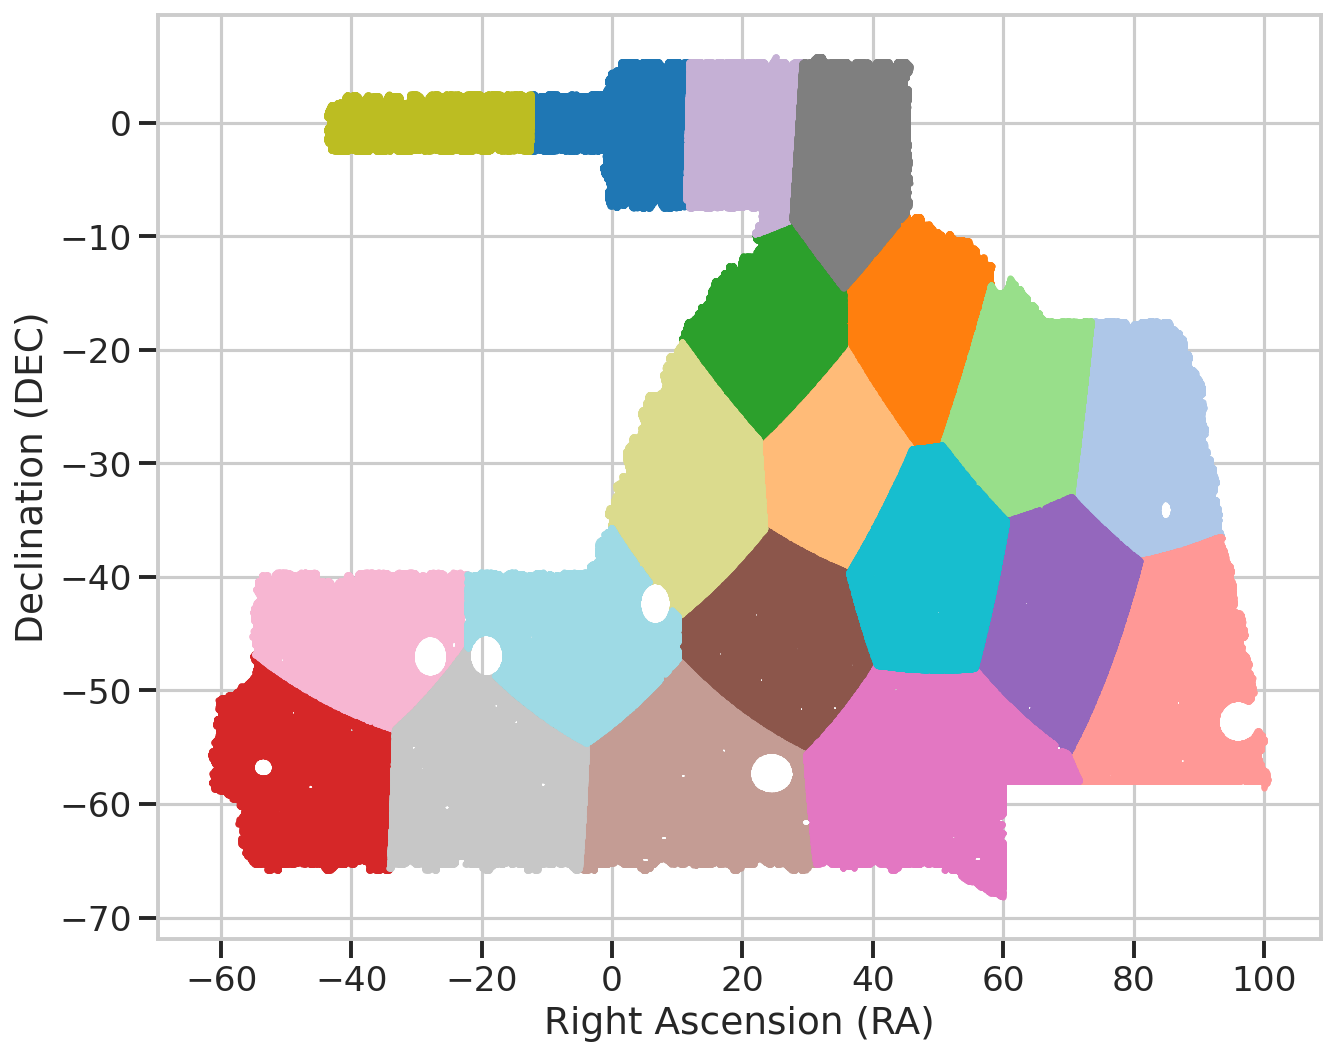

In [ ]:
#Visualizing the sky regions in the DES footprint
cmap = colormaps['tab20']

colors = cmap(np.linspace(0,1,cellno))

fig,ax = plt.subplots(figsize=(10,8),dpi=150)

for i in num:
    ax.scatter(ra[cell[i]],dec[cell[i]],s=2,color=colors[i])

ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (DEC)')
plt.show()

In [ ]:
#k-correction differences for relevant colors
kdiff_gi = colorcorr('g', redshift, (m_g-m_r), (m_r-m_i), (m_g-m_r), (m_g-m_i)) - colorcorr('i', redshift, (m_r-m_z), (m_r-m_z), (m_r-m_z), (m_r-m_z))
kdiff_gr = colorcorr('g', redshift, (m_g-m_r), (m_r-m_i), (m_g-m_r), (m_g-m_i)) - colorcorr('r', redshift, (m_g-m_i), (m_r-m_z), (m_r-m_i), (m_r-m_z))
kdiff_rz = colorcorr('r', redshift, (m_g-m_i), (m_r-m_z), (m_r-m_i), (m_r-m_z)) - colorcorr('z', redshift, (m_r-m_z), (m_r-m_z), (m_r-m_z), (m_r-m_z))
kdiff_gz = colorcorr('g', redshift, (m_g-m_r), (m_r-m_i), (m_g-m_r), (m_g-m_i)) - colorcorr('z', redshift, (m_r-m_z), (m_r-m_z), (m_r-m_z), (m_r-m_z))

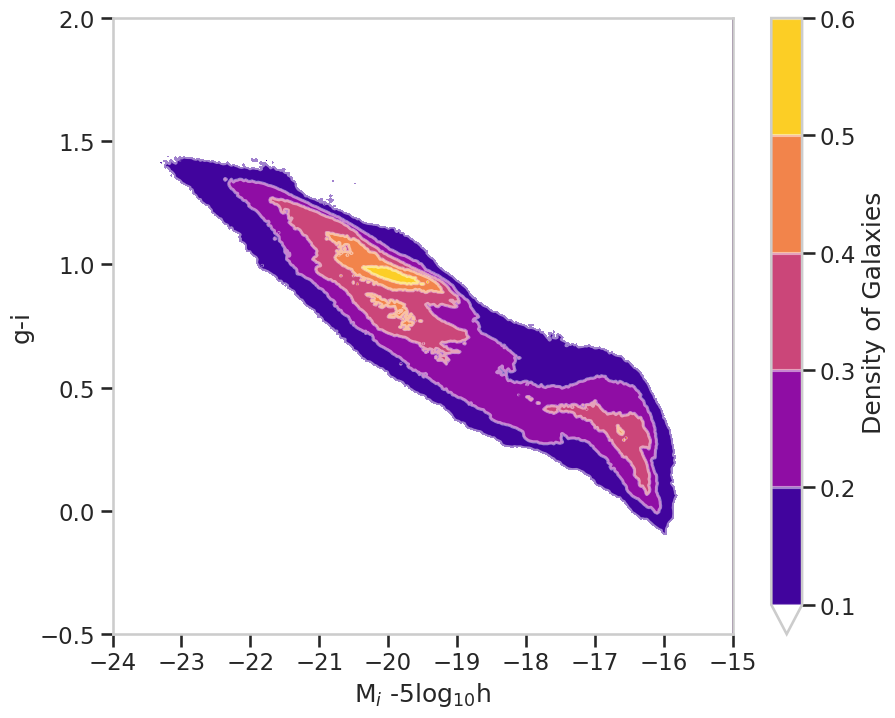

In [ ]:
#Visualization of the distinct galaxy populations
from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

y = m_g-m_i+kdiff_gi
x = total_M[2]

palette = copy(plt.get_cmap('plasma'))
palette.set_under('white', 1.0)

fig,ax = plt.subplots(figsize=(10,8),dpi=100)
h = ax.hist2d(x,y,bins=300,range=([-24,-15],[-0.5,2.]),cmap='viridis',density=True)
cntf = ax.contourf((h[1][1:]+h[1][:-1])/2,(h[2][1:]+h[2][:-1])/2,h[0],levels=6, cmap=palette, alpha=1,extend='min')
cnt = ax.contour((h[1][1:]+h[1][:-1])/2,(h[2][1:]+h[2][:-1])/2,h[0],levels=6, colors="white", alpha=0.5,vmin=0.2,vmax=0.6,extend='min')

cbar = fig.colorbar(cntf)
cbar.ax.set_ylabel('Density of Galaxies')
cbar.add_lines(cnt)

ax.set_xlabel("M$_{i}$ -5log$_{10}$h")
ax.set_ylabel("g-i")
plt.show()